In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Marketing_Analysis/')

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from tqdm import tqdm
from collections import Counter
from statistics import mode
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(10)
import tensorflow_hub as thub


In [ ]:
!pip install transformers

In [12]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFBertModel

In [7]:
labelles_reviews = pd.read_csv('text_cleaned.csv')
labelles_reviews = labelles_reviews.dropna()

In [9]:
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('/><br', ' ', regex=True)
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('br', ' ', regex=True)
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('<', ' ', regex=True)
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('>', ' ', regex=True)
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('/', ' ', regex=True)

labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.strip()

In [10]:
from sklearn.preprocessing import LabelEncoder
le_text = LabelEncoder()

labelles_reviews['class'] = le_text.fit_transform(labelles_reviews['sentiment_label'])

In [11]:
# make smaller set
from sklearn.model_selection import train_test_split

data_trunc, _ = train_test_split(labelles_reviews, test_size=0.7, random_state=42, stratify=labelles_reviews['class'] )

data_text_train_small, data_text_test_small = train_test_split(data_trunc, test_size=0.3, random_state=42, stratify=data_trunc['class'] )

X_train_raw_small = data_text_train_small['text_cleaned']
y_train_small = data_text_train_small['class']

X_test_raw_small = data_text_test_small['text_cleaned']
y_test_small = data_text_test_small['class']

In [12]:
# make smaller set
data_trunc, _ = train_test_split(labelles_reviews, test_size=0.7, random_state=42, stratify=labelles_reviews['class'] )

data_text_train_small, data_text_test_small = train_test_split(data_trunc, test_size=0.3, random_state=42, stratify=data_trunc['class'] )

X_train_raw_small = data_text_train_small['text_cleaned']
y_train_small = data_text_train_small['class']

X_test_raw_small = data_text_test_small['text_cleaned']
y_test_small = data_text_test_small['class']

In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
rev_len = labelles_reviews['text_cleaned'].apply(lambda x: len(x.split())).tolist()
print(max(rev_len))
print(np.mean(rev_len))

1810
35.3616089276337


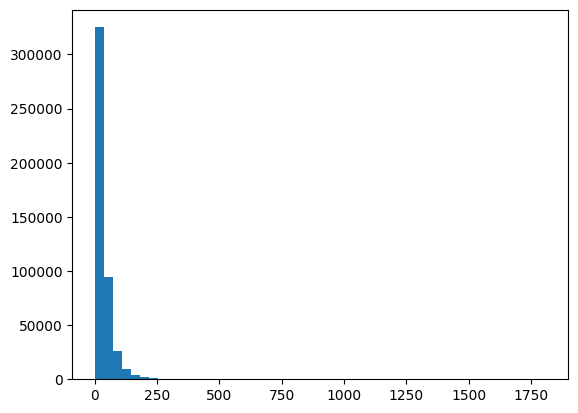

In [15]:
plt.hist(rev_len, bins=50)
plt.show()

In [6]:
max_len = 40

In [17]:
X_train = tokenizer(
    text=X_train_raw_small.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=X_test_raw_small.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [19]:
try:
    del model
except:
    2+2

In [15]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

y = Dense(3, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [16]:
#optimizer = Adam(
#    learning_rate=5e-05, # HF recommendation
#    epsilon=1e-08,
#    decay=0.01,
#    clipnorm=1.0
#)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

In [17]:
loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

In [18]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

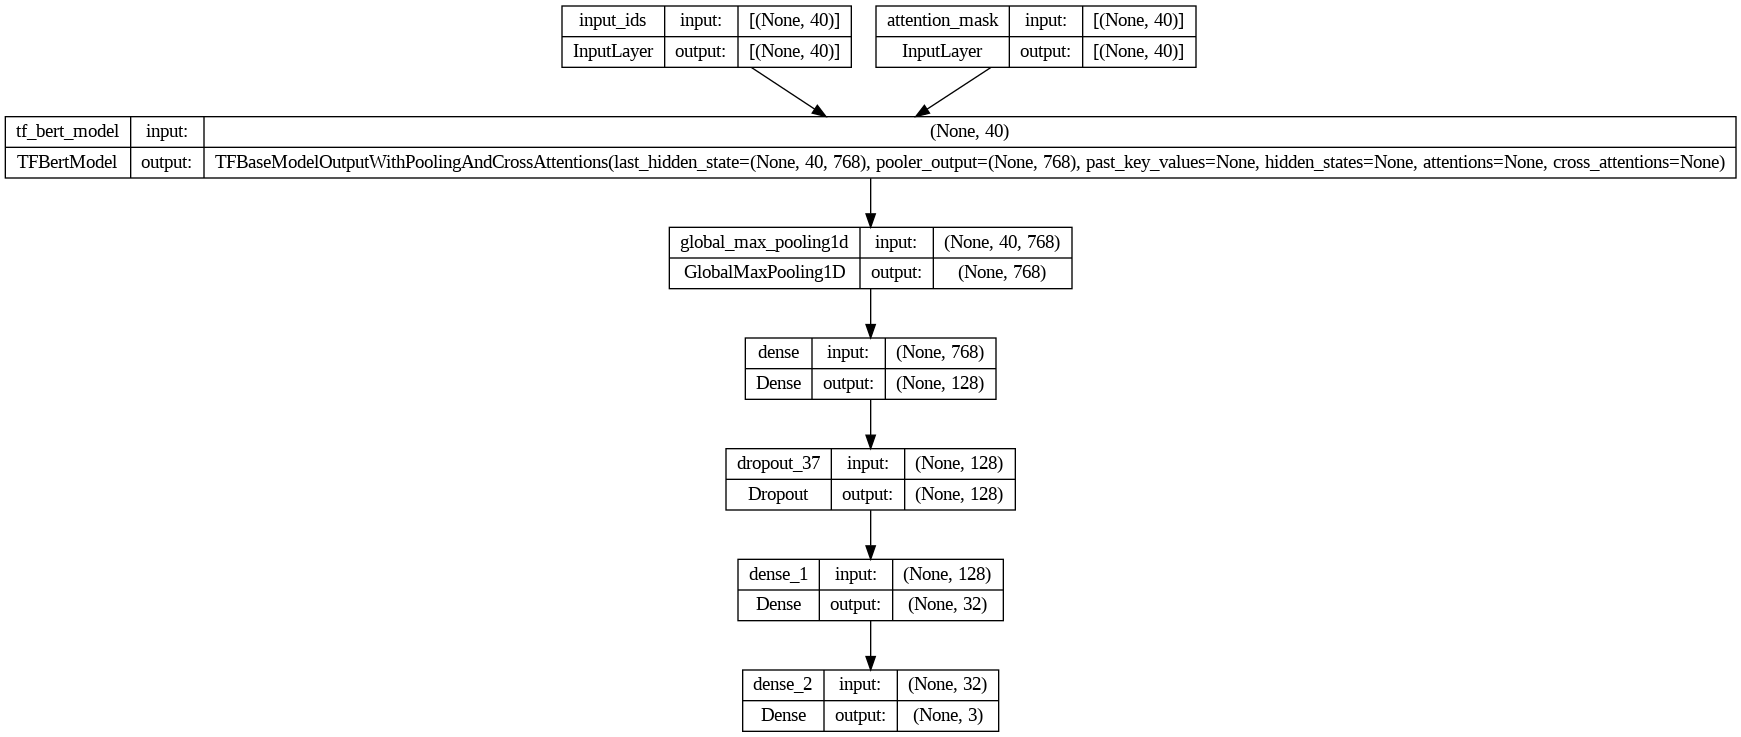

In [20]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                            

In [26]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [28]:
history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(y_train_small),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(y_test_small)),
    epochs=5,
    batch_size=64
)

Epoch 1/5
1519/1519 [==============================] - 845s 557ms/step - loss: 0.4758 - balanced_accuracy: 0.8080 - val_loss: 0.5667 - val_balanced_accuracy: 0.7685
Epoch 2/5
1519/1519 [==============================] - 876s 577ms/step - loss: 0.3977 - balanced_accuracy: 0.8453 - val_loss: 0.5981 - val_balanced_accuracy: 0.7617
Epoch 3/5
1519/1519 [==============================] - 876s 577ms/step - loss: 0.3202 - balanced_accuracy: 0.8798 - val_loss: 0.6328 - val_balanced_accuracy: 0.7775
Epoch 4/5
1519/1519 [==============================] - 846s 557ms/step - loss: 0.2547 - balanced_accuracy: 0.9077 - val_loss: 0.6891 - val_balanced_accuracy: 0.7792
Epoch 5/5
1519/1519 [==============================] - 877s 578ms/step - loss: 0.2072 - balanced_accuracy: 0.9259 - val_loss: 0.7193 - val_balanced_accuracy: 0.7788


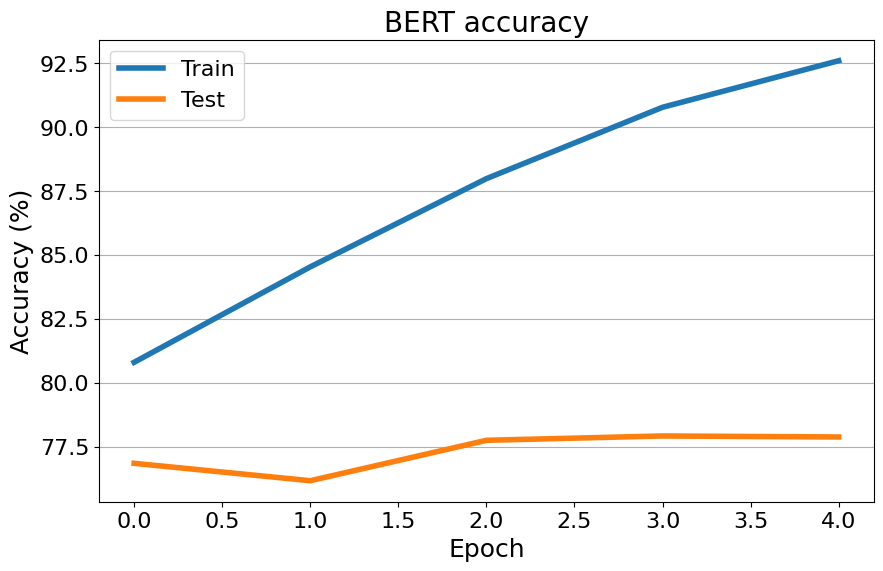

In [11]:
import keras
from matplotlib import pyplot as plt

plt.figure(figsize=(10,6))
plt.plot([i * 100 for i in history.history['balanced_accuracy']], label = "Train", linewidth = 4)
plt.plot([i * 100 for i in history.history['val_balanced_accuracy']] , label = "Test", linewidth = 4)
plt.title('BERT accuracy', fontsize=20)
plt.ylabel('Accuracy (%)', size=18)
plt.xlabel('Epoch', size=18)
plt.yticks(size=16)
plt.xticks(size=16)
plt.grid(axis='y')

plt.legend(loc='upper left', fontsize = 16)